**English to Spanish Translator**

In [252]:
# import shutil
# shutil.unpack_archive('/content/drive/MyDrive/Dataset/Global_Vectors_for_Word_Representations/glove.6B.zip', '/content/drive/MyDrive/Dataset/Global_Vectors_for_Word_Representations')

In [253]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras import preprocessing, utils
import tensorflow.keras.backend as k

In [254]:
# !pip install wget
# import wget
# url = 'https://raw.githubusercontent.com/Apress/artificial-neural-networks-with-tensorflow-2/main/ch08/spa.txt'
# wget.download(url,'/content/drive/MyDrive/Dataset/Global_Vectors_for_Word_Representations/spa.txt')

**Creating Datasets**

In [255]:
# reading data
with open('/content/drive/MyDrive/Dataset/Global_Vectors_for_Word_Representations/spa.txt',encoding='utf-8',errors='ignore') as file:
  text=file.read().split('\n')

In [256]:
text[:5]

['Go.\tVe.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)',
 'Go.\tVete.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)',
 'Go.\tVaya.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)',
 'Go.\tVáyase.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)',
 'Hi.\tHola.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)']

In [257]:
for t in text[100:110]:
  print(t)

Be good.	Sed buenas.	CC-BY 2.0 (France) Attribution: tatoeba.org #7932304 (Seael) & #7932308 (Seael)
Be good.	Sed buenos.	CC-BY 2.0 (France) Attribution: tatoeba.org #7932304 (Seael) & #7932309 (Seael)
Be good.	Sea buena.	CC-BY 2.0 (France) Attribution: tatoeba.org #7932304 (Seael) & #7932310 (Seael)
Be good.	Sea bueno.	CC-BY 2.0 (France) Attribution: tatoeba.org #7932304 (Seael) & #7932311 (Seael)
Be good.	Sean buenas.	CC-BY 2.0 (France) Attribution: tatoeba.org #7932304 (Seael) & #7932313 (Seael)
Be good.	Sean buenos.	CC-BY 2.0 (France) Attribution: tatoeba.org #7932304 (Seael) & #7932315 (Seael)
Be kind.	Sean gentiles.	CC-BY 2.0 (France) Attribution: tatoeba.org #1916315 (CK) & #2092229 (hayastan)
Be nice.	Sé agradable.	CC-BY 2.0 (France) Attribution: tatoeba.org #1916314 (CK) & #5769224 (arh)
Beat it.	Pírate.	CC-BY 2.0 (France) Attribution: tatoeba.org #37902 (CM) & #5769215 (arh)
Call me.	Llamame.	CC-BY 2.0 (France) Attribution: tatoeba.org #1553532 (CK) & #1555788 (hayastan)


In [258]:
input_texts = [] #encoder input
target_texts = [] # decoder input

In [259]:
NUM_SAMPLES = 10000
for line in text[:NUM_SAMPLES]:
  english, spanish = line.split('\t')[:2]
  target_text = spanish.lower()
  input_texts.append(english.lower())
  target_texts.append(target_text)

In [260]:
print(input_texts[:5],target_texts[:5])

['go.', 'go.', 'go.', 'go.', 'hi.'] ['ve.', 'vete.', 'vaya.', 'váyase.', 'hola.']


**Data Preprocessing**

*Cleaning Up Punctuation*

In [261]:
import string
print('Characters to be removed in preprocessing', string.punctuation)

Characters to be removed in preprocessing !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [262]:
def remove_punctuation(s):
  out = s.translate(str.maketrans("","",string.punctuation))
  return out

In [263]:
input_texts = [remove_punctuation(s) for s in input_texts]
target_texts = [remove_punctuation(s) for s in target_texts]

In [264]:
input_texts[:5],target_texts[:5]

(['go', 'go', 'go', 'go', 'hi'], ['ve', 'vete', 'vaya', 'váyase', 'hola'])

*Adding Start/End Tags*

In [265]:
# adding start and end tags
target_texts=['<start> ' + s + ' <end>' for s in target_texts]

In [266]:
target_texts[1]

'<start> vete <end>'

*Tokenizing Input Dataset*

In [267]:
tokenizer_in = Tokenizer()

#tokenizing the input texts
tokenizer_in.fit_on_texts(input_texts)

#vocab size of input
input_vocab_size = len(tokenizer_in.word_index) + 1
print('input_vocab_size:' + str(input_vocab_size))

input_vocab_size:2332


In [268]:
# Listing few items
input_tokens = tokenizer_in.index_word 
for k,v in sorted(input_tokens.items())[2000:2010]:
  print(k,v)

2001 sauce
2002 doctors
2003 plenty
2004 usually
2005 credible
2006 hopeless
2007 starving
2008 concept
2009 country
2010 thought


*Tokenizing Output Dataset*

In [269]:
#tokenizing output that is spanish translation
tokenizer_out = Tokenizer(filters='')
tokenizer_out.fit_on_texts(target_texts)
#vocab size of output
output_vocab_size = len(tokenizer_out.word_index) + 1
output_vocab_size

4964

In [270]:
# Listing few items
output_tokens = tokenizer_out.index_word
for k,v in sorted(output_tokens.items())[2000:2010]:
  print (k,v) 

2001 suyos
2002 ley
2003 palabras
2004 ausente
2005 delgaducho
2006 sucio
2007 adoptado
2008 violento
2009 roncando
2010 podríamos


**Creating Input Sequences**

In [271]:
#converting tokenized sentence into sequences
tokenized_input = tokenizer_in.texts_to_sequences(input_texts)

In [272]:
tokenized_input[200:220]

[[328, 5],
 [328, 5],
 [328, 5],
 [328, 5],
 [328, 5],
 [328, 5],
 [328, 5],
 [57, 4],
 [212, 8],
 [212, 8],
 [212, 8],
 [401, 36],
 [401, 36],
 [1476, 5],
 [73, 704],
 [73, 704],
 [49, 5],
 [49, 5],
 [74, 5],
 [134, 8]]

In [273]:
#max length of the input (Since sequences have different length)
maxlen_input = max( [ len(x) for x in tokenized_input ] )
maxlen_input

5

In [274]:
#padding sequence to a maximum fixed length
padded_input = preprocessing.sequence.pad_sequences(tokenized_input, maxlen=maxlen_input, padding='post')

In [275]:
padded_input[2000:2010]

array([[  1, 613, 195,   0,   0],
       [  1,  54, 109,   0,   0],
       [  1,  54, 109,   0,   0],
       [  1,  54, 109,   0,   0],
       [  1,  54, 182,   0,   0],
       [  1,  54,  14,   0,   0],
       [  1,  54,  98,   0,   0],
       [  1,  54,  98,   0,   0],
       [  1,  54,  10,   0,   0],
       [  1,  54,  10,   0,   0]], dtype=int32)

In [276]:
encoder_input_data = np.array( padded_input )
print(encoder_input_data.shape)

(10000, 5)


**Creating Output Sequences**


In [277]:
#converting tokenized text into sequences
tokenized_output = tokenizer_out.texts_to_sequences(target_texts)
tokenized_output[:5]

[[1, 70, 2], [1, 235, 2], [1, 282, 2], [1, 485, 2], [1, 434, 2]]

In [278]:
output_vocab_size=len(tokenizer_out.word_index) + 1
output_vocab_size

4964

In [279]:
# teacher forcing
for i in range(len(tokenized_output)) :
  tokenized_output[i] = tokenized_output[i][1:]
tokenized_output[:5]

[[70, 2], [235, 2], [282, 2], [485, 2], [434, 2]]

In [280]:
maxlen_output = max( [ len(x) for x in tokenized_output ] )
padded_output = preprocessing.sequence.pad_sequences(tokenized_output, maxlen=maxlen_output,padding='post')

In [281]:
padded_output[2000:2010]

array([[  11, 1147,   26,  108,    2,    0,    0,    0,    0],
       [  51,   17,  135,    2,    0,    0,    0,    0,    0],
       [  11,   51,   17,  135,    2,    0,    0,    0,    0],
       [  11,   51,   13,  224,    2,    0,    0,    0,    0],
       [  51,   59,    2,    0,    0,    0,    0,    0,    0],
       [  51,   20,    2,    0,    0,    0,    0,    0,    0],
       [  28,   51,    2,    0,    0,    0,    0,    0,    0],
       [  37,   51,    2,    0,    0,    0,    0,    0,    0],
       [  51,   88,    2,    0,    0,    0,    0,    0,    0],
       [  51,   19,    2,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

In [282]:
# converting to numpy
decoder_input_data = np.array( padded_output )

In [283]:
decoder_input_data[2000:2010]

array([[  11, 1147,   26,  108,    2,    0,    0,    0,    0],
       [  51,   17,  135,    2,    0,    0,    0,    0,    0],
       [  11,   51,   17,  135,    2,    0,    0,    0,    0],
       [  11,   51,   13,  224,    2,    0,    0,    0,    0],
       [  51,   59,    2,    0,    0,    0,    0,    0,    0],
       [  51,   20,    2,    0,    0,    0,    0,    0,    0],
       [  28,   51,    2,    0,    0,    0,    0,    0,    0],
       [  37,   51,    2,    0,    0,    0,    0,    0,    0],
       [  51,   88,    2,    0,    0,    0,    0,    0,    0],
       [  51,   19,    2,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

In [284]:
#decoder target output
decoder_target_one_hot=np.zeros((len(input_texts), maxlen_output, output_vocab_size), dtype='float32')
decoder_target_one_hot.shape

(10000, 9, 4964)

In [285]:
for i,d in enumerate(padded_output):
  for t,word in enumerate(d):
    decoder_target_one_hot[i,t,word]=1

In [286]:
print(decoder_target_one_hot.shape)
decoder_target_one_hot[0]

(10000, 9, 4964)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [287]:
#creating dictionary of words corresponding to vectors
print('Indexing word vectors.')
embeddings_index = {}
# Use this open command in case of downloading using wget above
#f = open('glove.6B.200d.txt', encoding='utf-8')
# we can choose any dimensions 50 100 200 300
f = open('/content/drive/MyDrive/Dataset/Global_Vectors_for_Word_Representations/glove.6B.200d.txt', encoding='utf-8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [288]:
embeddings_index["any"]

array([ 6.3113e-01,  4.3183e-01,  2.3103e-01, -6.4909e-01,  2.3744e-01,
        4.4619e-01, -8.6148e-01,  2.9341e-01,  8.0033e-02,  8.5633e-03,
        1.0165e-01,  6.2783e-01,  2.5047e-01,  5.2425e-02,  6.3045e-01,
       -4.0008e-02,  2.5212e-01,  6.2147e-01,  6.6967e-02, -7.9787e-02,
       -2.1607e-02,  3.4236e+00, -4.7925e-02,  2.4620e-01, -2.8834e-02,
        4.0330e-02, -2.7858e-01, -2.7939e-01,  3.5606e-01, -5.7373e-01,
       -9.9960e-02, -3.2374e-01,  1.7812e-01,  2.0671e-02,  2.3637e-01,
       -1.7074e-01, -4.9345e-01, -4.0289e-01, -3.4184e-01, -1.9405e-01,
        4.2506e-01, -3.0081e-01,  1.9997e-01,  6.7150e-01, -1.0461e-01,
       -8.7182e-03, -4.4562e-02,  1.7045e-01,  6.5912e-01,  8.9096e-02,
       -1.4178e-01, -5.8817e-01, -2.9699e-01,  4.5901e-01,  6.1475e-01,
        2.2455e-01,  2.8778e-01, -8.0486e-02, -1.6625e-01,  4.9791e-01,
       -1.0441e-02, -1.7307e-01, -1.1364e-01, -1.7177e-01,  6.5001e-01,
       -2.0709e-01, -2.5923e-03,  6.8332e-01,  1.3556e-01,  4.28

**Creating Subset**

In [289]:
#embedding matrix
num_words = len(tokenizer_in.word_index) + 1
word2idx_input = tokenizer_in.word_index
embedding_matrix = np.zeros((num_words, 200))
for word,i in word2idx_input.items():
  if i<num_words:
    embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(2332, 200)

**Defining Embedding Layer**

In [290]:
#lstm hidden dimensions
LATENT_DIM = 256
#embeding layer dimensions
EMBEDDING_DIM = 200

In [291]:
embedding_layer=Embedding(input_vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=maxlen_input)

**Defining Encoder**

In [292]:
#encoder
encoder_inputs = Input(shape=(maxlen_input,), name = 'encoderinput')

In [293]:
encoder_input = embedding_layer(encoder_inputs)

In [294]:
encoder = Bidirectional(
    LSTM(
        LATENT_DIM, 
         return_sequences=True, 
         dropout = 0.3
         ), 
    name = 'encoder_bidirection'
)

In [295]:
encoder_outputs = encoder(encoder_input)

In [296]:
encoder_outputs.shape

TensorShape([None, 5, 512])

**Defining Decoder**

In [297]:
decoder_inputs = Input(shape=(maxlen_output,), name='decoder_input')

In [298]:
decoder_embedding = Embedding(output_vocab_size, EMBEDDING_DIM, name='decoder_embedding')

In [299]:
decoder_input = decoder_embedding(decoder_inputs)

In [300]:
decoder_input.shape

TensorShape([None, 9, 200])

In [301]:
decoder_lstm = LSTM(LATENT_DIM, return_state = True, name = 'decoder_lstm')

In [302]:
decoder_dense = Dense(output_vocab_size, activation='softmax', name='decoder_dense')

**Attention Network**

In [303]:
# Computing alphas
def softmax_attention(x):
  assert(k.ndim(x)>2)

  e=k.exp(x-k.max(x,axis=1,keepdims=True))
  s=k.sum(e,axis=1,keepdims=True)
  return e/s
  

***Attention Layers***

In [304]:
# We create an attention_repeat that acts as a bridge between the encoder and decoder modules.
attention_repeat = RepeatVector(maxlen_input)

In [305]:
attention_concat = Concatenate(axis=-1)

In [306]:
dense1_layer = Dense(10,activation='tanh')

In [307]:
dense2_layer = Dense(1,activation = softmax_attention)

In [308]:
dot_layer = Dot(axes=1)

***Attention Context***

In [309]:
def context_attention(h, st_1):
  st_1 = attention_repeat(st_1)
  x = attention_concat([h,st_1])
  x = dense1_layer(x)
  alphas = dense2_layer(x)
  context = dot_layer([alphas,h])
  return context

**Collecting Outputs**

In [310]:
# Collect outputs over all time steps
initial_s = Input(shape=(LATENT_DIM,), name='s0')
initial_c = Input(shape=(LATENT_DIM,), name='c0')

In [311]:
context_last_word_concat_layer = Concatenate(axis=2)

In [312]:
s = initial_s
c = initial_c

In [313]:
outputs = []

In [314]:
import tensorflow.keras.backend as k
#collect output in a list at first
for t in range(maxlen_output): #ty times
  #get the context using attention mechanism
  context = context_attention(encoder_outputs,s)
  
  #we need a different layer for each time step
  selector = Lambda(lambda x: x[:,t:t+1])
  x_t = selector(decoder_input)

  #combine
  decoder_lstm_input = context_last_word_concat_layer([context,x_t])
  
  #pass the combined [context,last word] into lstm
  #along with [s,c]
  #get the new[s,c] and output
  out,s,c = decoder_lstm(decoder_lstm_input, initial_state=[s,c])
  
  #final dense layer to get next word prediction
  decoder_outputs = decoder_dense(out)
  outputs.append(decoder_outputs)


In [315]:
outputs

[<KerasTensor: shape=(None, 4964) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4964) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4964) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4964) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4964) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4964) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4964) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4964) dtype=float32 (created by layer 'decoder_dense')>,
 <KerasTensor: shape=(None, 4964) dtype=float32 (created by layer 'decoder_dense')>]

In [316]:
def stack(x):
  x=k.stack(x)
  x=k.permute_dimensions(x,pattern=(1,0,2))
  return x

In [317]:
stacker = Lambda(stack)
outputs = stacker(outputs)
outputs

<KerasTensor: shape=(None, 9, 4964) dtype=float32 (created by layer 'lambda_39')>

**Defining Model**

In [318]:
model=Model(inputs=[encoder_inputs, decoder_inputs, initial_s, initial_c], outputs=outputs)

In [319]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoderinput (InputLayer)       [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 5, 200)       466400      encoderinput[0][0]               
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 256)]        0                                            
__________________________________________________________________________________________________
encoder_bidirection (Bidirectio (None, 5, 512)       935936      embedding_5[0][0]                
____________________________________________________________________________________________

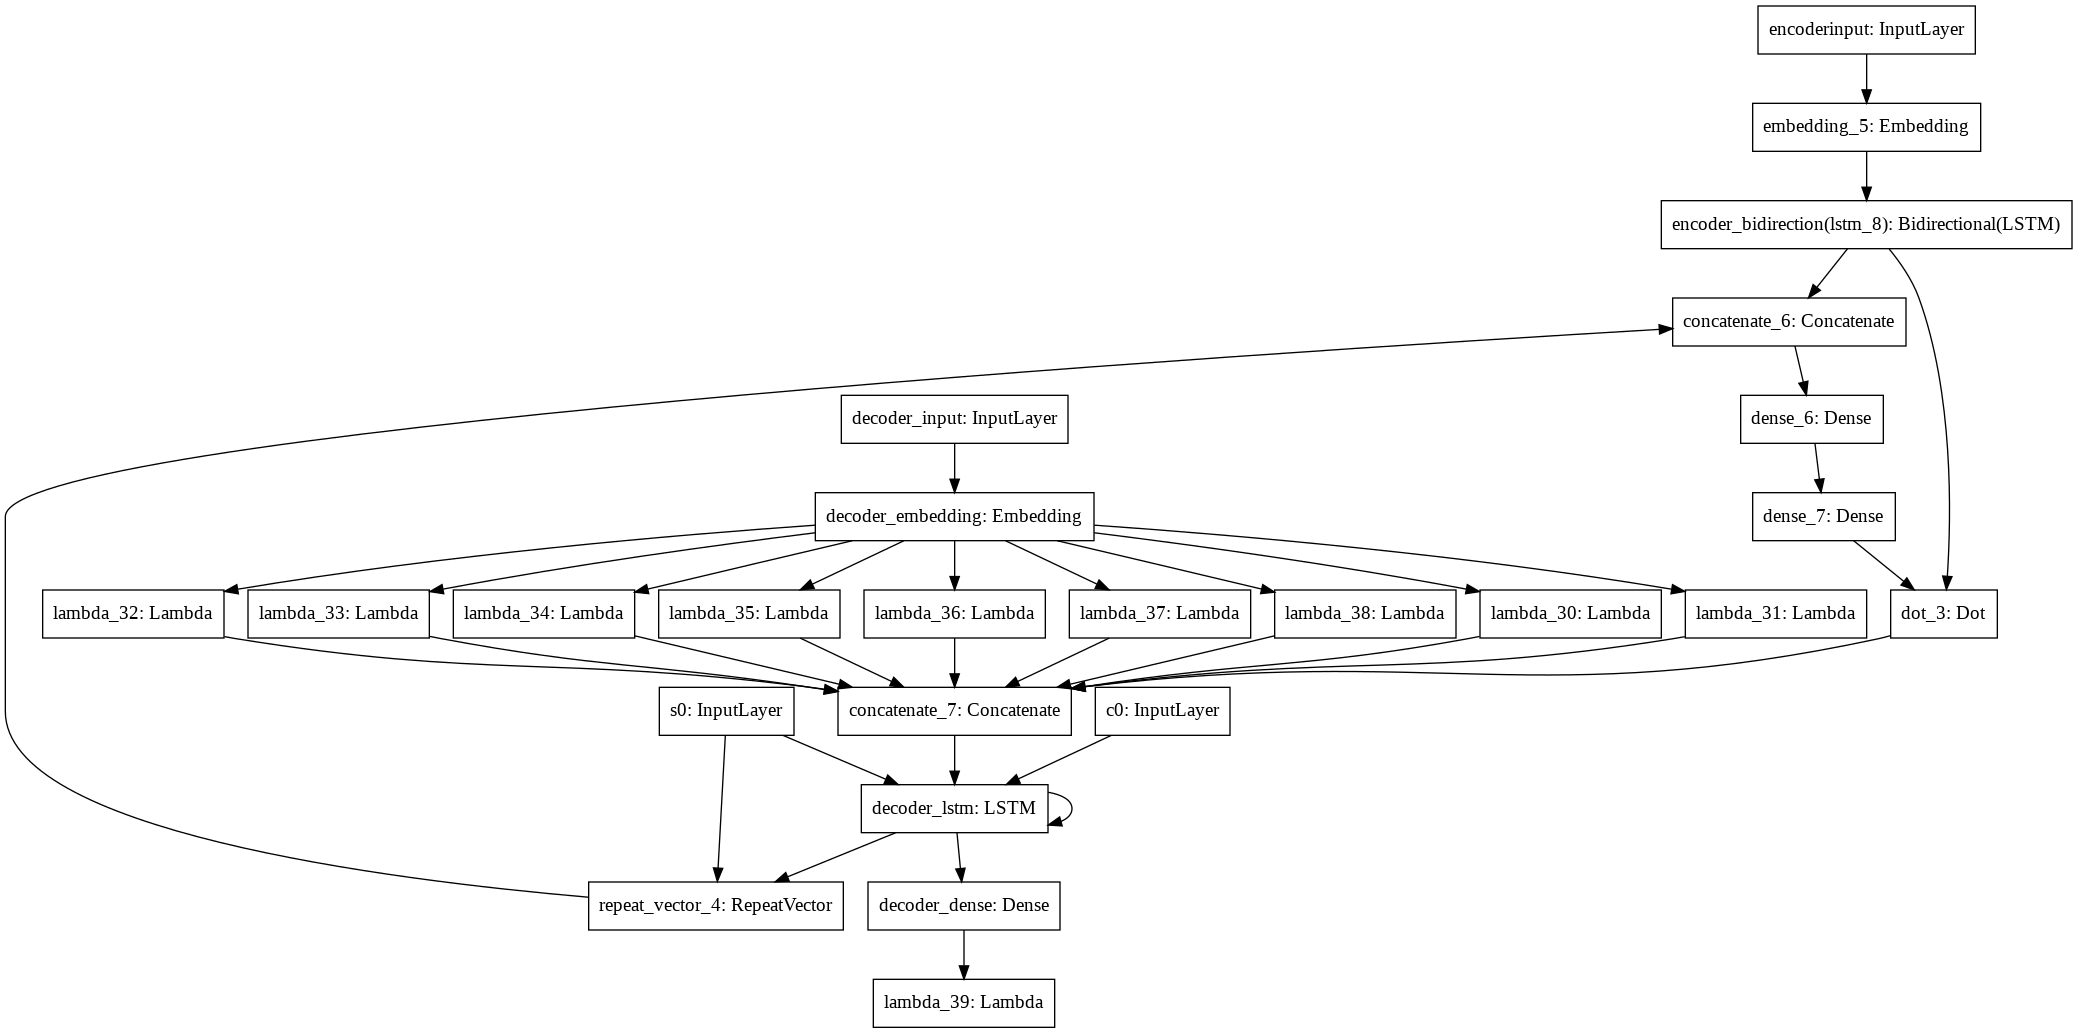

In [320]:
tf.keras.utils.plot_model(model)

In [321]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Model Training**

In [322]:
# We create the initial states by taking zero as inputs.
initial_s_training = np.zeros((NUM_SAMPLES,LATENT_DIM))
initial_c_training = np.zeros(shape=(NUM_SAMPLES,LATENT_DIM))

In [323]:
# We train the model using the following statement:
R = model.fit(
    [encoder_input_data,decoder_input_data,initial_s_training,initial_c_training],
    decoder_target_one_hot,
    batch_size=100,
    epochs=100,
    validation_split=0.3
)

Epoch 1/100
70/70 [==============================] - 66s 713ms/step - loss: 3.5015 - accuracy: 0.5815 - val_loss: 3.0108 - val_accuracy: 0.5288
Epoch 2/100
70/70 [==============================] - 46s 657ms/step - loss: 2.3991 - accuracy: 0.6254 - val_loss: 2.8801 - val_accuracy: 0.5731
Epoch 3/100
70/70 [==============================] - 46s 656ms/step - loss: 2.2996 - accuracy: 0.6474 - val_loss: 2.8525 - val_accuracy: 0.5963
Epoch 4/100
70/70 [==============================] - 46s 654ms/step - loss: 2.2382 - accuracy: 0.6577 - val_loss: 2.8179 - val_accuracy: 0.5974
Epoch 5/100
70/70 [==============================] - 46s 652ms/step - loss: 2.1930 - accuracy: 0.6639 - val_loss: 2.8111 - val_accuracy: 0.6080
Epoch 6/100
70/70 [==============================] - 46s 652ms/step - loss: 2.1491 - accuracy: 0.6698 - val_loss: 2.7577 - val_accuracy: 0.6137
Epoch 7/100
70/70 [==============================] - 48s 688ms/step - loss: 2.1025 - accuracy: 0.6755 - val_loss: 2.7269 - val_accuracy:

**Inference**

<br>
Encoding

In [326]:
encoder_model = Model(encoder_inputs, encoder_outputs)

In [327]:
encoder_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoderinput (InputLayer)    [(None, 5)]               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 5, 200)            466400    
_________________________________________________________________
encoder_bidirection (Bidirec (None, 5, 512)            935936    
Total params: 1,402,336
Trainable params: 1,402,336
Non-trainable params: 0
_________________________________________________________________


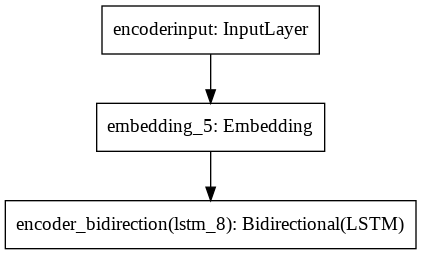

In [328]:
tf.keras.utils.plot_model(encoder_model)

Decoding

In [329]:
encoder_outputs_as_input = Input(shape=(maxlen_input, LATENT_DIM* 2,))

In [330]:
decoder_input_embedding = Input(shape=(1,))

In [331]:
# We call decoder_embedding to create an input for the decoder with a single word input
decoder_input_ = decoder_embedding(decoder_input_embedding)

In [332]:
# We calculate the context at each time step by calling our one_step_ attention function:
context = context_attention(encoder_outputs_as_input, initial_s)

In [333]:
# We compute the decoder input by calling our context_last_word_concat_layer method.
decoder_lstm_input = context_last_word_concat_layer([context, decoder_input_])

In [334]:
# We call the decoder and collect its outputs.
out, s, c = decoder_lstm(decoder_lstm_input,initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(out)

In [335]:
# Finally, we define the Decoder model as follows:
decoder_model = Model(
    inputs=[decoder_input_embedding,encoder_outputs_as_input,initial_s,initial_c],
    outputs=[decoder_outputs, s, c]
)

In [336]:
decoder_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
s0 (InputLayer)                 [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5, 512)]     0                                            
__________________________________________________________________________________________________
repeat_vector_4 (RepeatVector)  (None, 5, 256)       0           s0[0][0]                         
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 5, 768)       0           input_1[0][0]                    
                                                                 repeat_vector_4[9][0]      

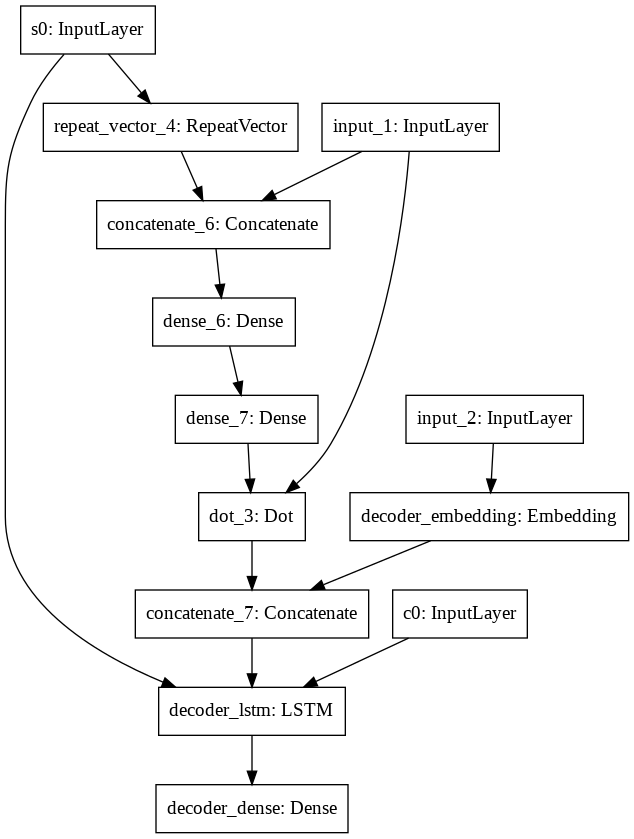

In [337]:
tf.keras.utils.plot_model(decoder_model)

**Translating**

In [338]:
word2index_input=tokenizer_in.word_index
word2index_output=tokenizer_out.word_index

In [339]:
#reverse mapping integer to words for english
idx2word_eng = {v:k for k, v in word2index_input.items()}
#reverse mapping integer to words for spanish
idx2word_trans = {v:k for k, v in word2index_output.items()}

In [340]:
# function for decoding a sentence consisting of a few words
def decode_sequence(input_seq):
  # we encode the input as state vectors
  enc_out = encoder_model.predict(input_seq)

  # generate the empty target sequence of length 1
  target_seq = np.zeros((1, 1))

  # We populate the first character of the target sequence with the start
  # character. Note that the tokenizer lowercases all words.
  target_seq[0, 0] = word2index_output['<start>']

  # We use the <end> token for breaking the loop:
  End_statement = word2index_output['<end>']
  
  # As the states are updated in each loop, we initialize them on each iteration.
  s = np.zeros((1,LATENT_DIM))
  c = np.zeros((1,LATENT_DIM))

  # For storing the translated sequence, we declare an output array.
  output_sentence = []

  # define a for loop for generating the output
  for _ in range(maxlen_output):
    out, s, c = decoder_model.predict([target_seq, enc_out, s, c])
    
    # We pick up the next word based on the prediction probabilities of the decoder output.
    index = np.argmax(out.flatten())

    if End_statement == index:
      break

    word = ''
    if index > 0:
      word = idx2word_trans[index]
      output_sentence.append(word)
    
    # We update the decoder input, which is just the word last generated
    target_seq[0, 0] = index

  # return the combined output sequence to the caller.
  return ' '.join(output_sentence)

In [341]:
count = 0
while (count < 5):
  input_text = [str(input('input the sentence : '))]
  seq = tokenizer_in.texts_to_sequences(input_text)
  input_seq = pad_sequences(seq,maxlen=maxlen_input, padding='post')
  translation = decode_sequence(input_seq)
  print('Predicted translation:', translation)
  count+=1

input the sentence : Hello
Predicted translation: hola
input the sentence : How are you ?
Predicted translation: ¿ellos están
input the sentence : What are you doing?
Predicted translation: ¿qué qué son
input the sentence : see you later
Predicted translation: te vemos temprano
input the sentence : bye
Predicted translation: sonríe hola
